In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import geopandas as gpd
import heapq
import random
import timeit

import sys
sys.path.append('./../exploration') # this is where the magic is going down
sys.path.append('./..')

from intersections_and_roads import *
from search import *
%matplotlib inline

In [2]:
# Read in the geolocation data
intersections = gpd.read_file('../cambridgegis_data_trans/Intersections/TRANS_Intersections.topojson')
street_centerline = gpd.read_file('../cambridgegis_data_trans/Street_Centerlines/TRANS_Centerlines.topojson')
intersection_graph, connection_dict = build_intersection_graph(intersections=intersections, street_centerline=street_centerline)

In [3]:
# randomly select a start and an end point on the graph for test
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [4]:
def a_star_search(start, end, intersection_graph, connection_dict, get_road_cost, heuristic=null_heuristic):
    print start.id, end.id
    fringe = PriorityQueue()

    discovered_nodes = set()
    route_to_goal = dict()
    route_to_goal[start.id] = {'nodes': [], 'connections': []}

    fringe.push(start, 0)

    while not fringe.isEmpty():
        node = fringe.pop()
        discovered_nodes.add(node)

        #at the goal node
        if node.id == end.id:
            print 'end'
            return route_to_goal[node.id]
        
        connections = map(lambda ID: connection_dict[ID], node.get_connections())
        
        for connection in connections:
            child_id = connection.get_child(node.id)
            child = intersection_graph[child_id]

            #if we have not visited this node
            if not child in discovered_nodes:
                road_list = route_to_goal[node.id]['nodes'] + [child.id]
                connection_list = route_to_goal[node.id]['connections'] + [connection.id]
                cost_of_road_list = get_road_cost(road_list, connection_list, intersection_graph, connection_dict)
                
                # If we already have a route to this node
                if child.id in route_to_goal:
                    current_best_route = route_to_goal[child.id]
                    current_best_cost = get_road_cost(current_best_route['nodes'], current_best_route['connections'], intersection_graph, connection_dict)
#                     print 'cost', cost_of_road_list,  current_best_cost
                    if cost_of_road_list < current_best_cost:
                        route_to_goal[child.id] = {'nodes': road_list, 'connections': connection_list}
                else:
                    route_to_goal[child.id] = {'nodes': road_list, 'connections': connection_list}

                # update the fringe with this node

                fringe.update(child, get_road_cost(route_to_goal[child.id]['nodes'], route_to_goal[child.id]['connections'], intersection_graph, connection_dict) + heuristic(child, end))   

In [5]:
# search the graph
route = a_star_search(start, end, intersection_graph, connection_dict, get_road_cost)

792 235
end


In [6]:
print route

{'connections': [u'St-P_St_3', u'St-P_St_1', u'Prospec_St_3', u'Prospec_St_4', u'Prospec_St_5', u'Prospec_St_6', u'Prospec_St_7', u'Hampshi_St_14', u'Hampshi_St_15', u'Hampshi_St_16', u'Hampshi_St_17', u'Hampshi_St_18', u'Beacon_St_1', u'Beacon_St_2', u'Beacon_St_3', u'Beacon_St_4', u'Beacon_St_5', u'Beacon_St_6', u'Prentis_St_3', u'Prentis_St_2', u'Prentis_St_1', u'Oxford_St_9', u'Oxford_St_10', u'Beacon_St_10', u'Somervi_Ave_1', u'Somervi_Ave_2', u'Massach_Ave_74', u'Massach_Ave_75'], 'nodes': [u'796', u'1430', u'1380', u'1239', u'709', u'694', u'1109', u'1073', u'1068', u'1034', u'1024', u'1796', u'1795', u'894', u'882', u'874', u'870', u'861', u'330', u'331', u'333', u'302', u'650', u'644', u'247', u'241', u'238', u'235']}


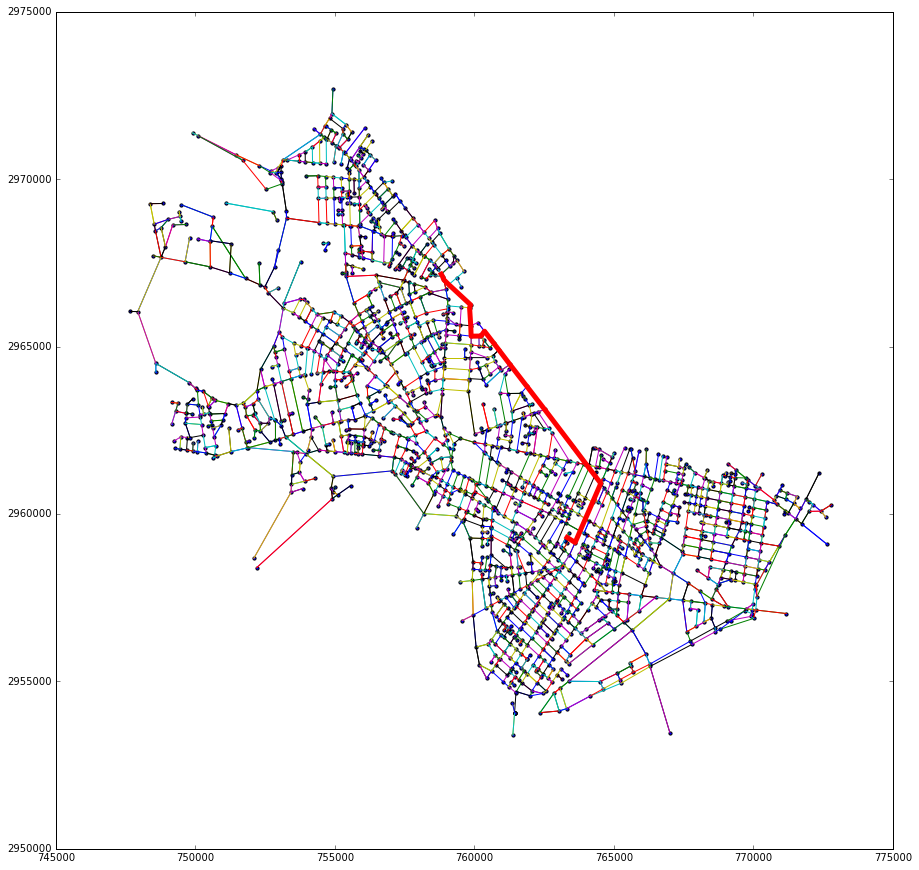

In [7]:
plot_graph(intersection_graph, connection_dict, [route['nodes']])

In [8]:
p1 = intersection_graph[np.random.choice(intersection_graph.keys())]
p2 = intersection_graph[np.random.choice(intersection_graph.keys())]

simulated_annealing(intersection_graph, connection_dict, get_road_cost, null_heuristic, starting_points=[p1,p2])

TypeError: unsupported operand type(s) for +: 'instance' and 'instance'

In [ ]:
# timing for comparing heuristics down the line
def test():
#     start = intersection_graph[np.random.choice(intersection_graph.keys())]
#     end = intersection_graph[np.random.choice(intersection_graph.keys())]
    a_star_search(start, end, intersection_graph)

timeit.timeit("test()", setup="from __main__ import *", number=10)